In [2]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,LabelEncoder,PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor 
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 1300)
pd.set_option('display.max_columns', 1300)
pd.set_option('display.width', 1300)

In [3]:
# prepare data

# loop thr
trainData = pd.read_csv('CS98XRegressionTrain.csv')
trainData = pd.DataFrame(trainData)


testData = pd.read_csv('CS98XRegressionTest_m.csv')
testData = pd.DataFrame(testData)

#print(wholeList)

In [4]:
# check shape of the data
print('train data shape:',trainData.shape)
print('test data shape:',testData.shape)


train data shape: (453, 15)
test data shape: (114, 15)


In [5]:
# check the info of the data
print('train data info:',trainData.info())
print('test data info:',testData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   top genre  438 non-null    object
 4   year       453 non-null    int64 
 5   bpm        453 non-null    int64 
 6   nrgy       453 non-null    int64 
 7   dnce       453 non-null    int64 
 8   dB         453 non-null    int64 
 9   live       453 non-null    int64 
 10  val        453 non-null    int64 
 11  dur        453 non-null    int64 
 12  acous      453 non-null    int64 
 13  spch       453 non-null    int64 
 14  pop        453 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 53.2+ KB
train data info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------   

In [6]:
# check if duplicate row exist in test data and train data

print('train data duplicated:',trainData.duplicated().any())
print('test data duplicated:',testData.duplicated().any())

train data duplicated: False
test data duplicated: False


In [7]:
# check if any NaN cell in both train and test data
print('train data NaN:',trainData.columns[trainData.isnull().any()])
print('test data NaN:',testData.columns[testData.isnull().any()])


train data NaN: Index(['top genre'], dtype='object')
test data NaN: Index(['top genre'], dtype='object')


In [8]:
# filter out the NaN rows - in train data only, even there are empty in test data, it will be ingore as this is not related to the training
# 1) run drop if empty found
# 2) create a new dataframe that for future use
if not(trainData.columns[trainData.isnull().any()].isnull()):
    trainDataClean = trainData.drop(trainData[trainData['top genre'].isnull()].index)
testDataClean = testData.copy()

# check if any NaN cell in both train and test data after removal
print('after train data NaN:',trainDataClean.columns[trainDataClean.isnull().any()])
print('after test data NaN:',testDataClean.columns[testDataClean.isnull().any()])

after train data NaN: Index([], dtype='object')
after test data NaN: Index(['top genre'], dtype='object')


In [9]:
# encode the object columns - train data and test data,
# reason: using label encoder and not oneHotEncoder, the size of the new column will created is massive, label encoder is more suitable to turn object(string) to numerical for further analysis
encoder = LabelEncoder()
encodeCols = ["title","artist","top genre"]
for col in encodeCols:
    encoder.fit(trainDataClean[col])
    trainDataClean[col] = encoder.transform(trainDataClean[col])
    
for col in encodeCols:
    encoder.fit(testDataClean[col])
    testDataClean[col] = encoder.transform(testDataClean[col])

In [10]:
# 
print (trainDataClean.describe())


               Id       title      artist   top genre         year         bpm        nrgy        dnce          dB        live         val         dur       acous        spch         pop
count  438.000000  438.000000  438.000000  438.000000   438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000
mean   227.600457  218.038813  162.383562   32.547945  1990.881279  118.326484   60.504566   59.780822   -8.787671   17.605023   59.625571  228.267123   32.191781    5.671233   61.557078
std    130.463047  125.990359   95.913047   26.075252    16.697047   25.175735   22.089660   15.404757    3.591005   13.807492   24.480160   63.426812   29.279912    5.571392   12.759353
min      1.000000    0.000000    0.000000    0.000000  1948.000000   62.000000    7.000000   18.000000  -24.000000    2.000000    6.000000   98.000000    0.000000    2.000000   26.000000
25%    116.250000  109.250000   79.250000    4.000000  1976.00000

In [11]:
# a brief review of encoded and remove empty cell dataframe in train data 
print("train data - after encode:\n",trainDataClean.head())

train data - after encode:
    Id  title  artist  top genre  year  bpm  nrgy  dnce  dB  live  val  dur  acous  spch  pop
0   1    265      54          1  1996  107    31    45  -8    13   28  150     75     3   44
2   3    160      19          1  1979  105    36    63  -9    13   67  245     11     3   77
3   4    422      18          1  1980  170    28    47 -16    13   33  232     25     3   67
4   5    138      92         68  1973  121    47    56  -8    15   40  193     45     3   63
5   6    139      40         80  2010  110    56    71  -7    12   23  223     15     6   74


Text(0.5, 1.0, 'Corelation of all columns')

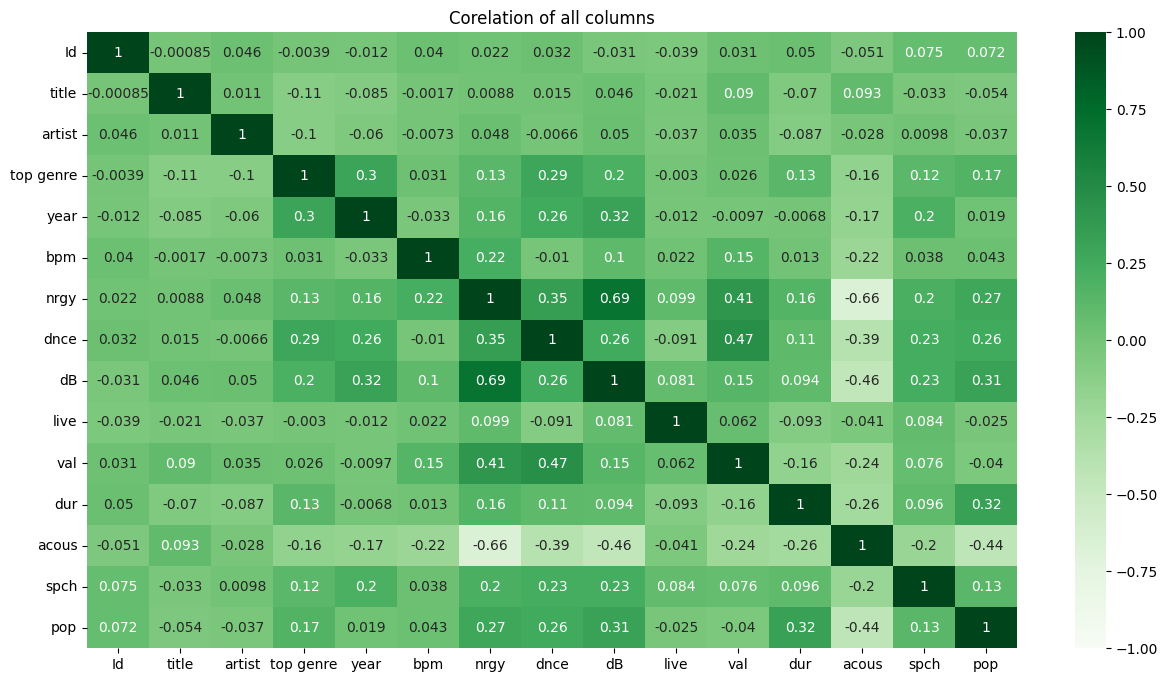

In [12]:
# corelation before remove outliner - train data
corelation = trainDataClean.corr()
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(trainDataClean.corr(), center=0, cmap='Greens',vmin=-1, vmax=1, annot=True)
ax.set_title('Corelation of all columns')

In [13]:
# filter the outliner of each columns in train data 
th = 5
outlinerList={}
outlinerCols = trainDataClean.columns
for col in outlinerCols:
    mean = np.mean(trainDataClean[col])
    std=np.std(trainDataClean[col])
    out_list=[]
    for i in trainDataClean[col]:
        z=(i-mean)/std
        if z > th:
            out_list.append(i)
    if (out_list):
        outlinerList[col]= out_list
print("outliers : ", outlinerList)

outliers :  {'live': [93], 'spch': [38, 37, 36, 47]}


In [14]:
# extract outliner in the dataframe and present the shape of dataframe before and after extraction

print("before remove outliner:",trainDataClean.shape)
for key,value in outlinerList.items():
    print(key,value)
    for i in value:
        trainDataClean.drop(trainDataClean[trainDataClean[key]==i].index, inplace = True)

print("after remove outliner:",trainDataClean.shape)

before remove outliner: (438, 15)
live [93]
spch [38, 37, 36, 47]
after remove outliner: (433, 15)


Text(0.5, 1.0, 'Corelation of all columns')

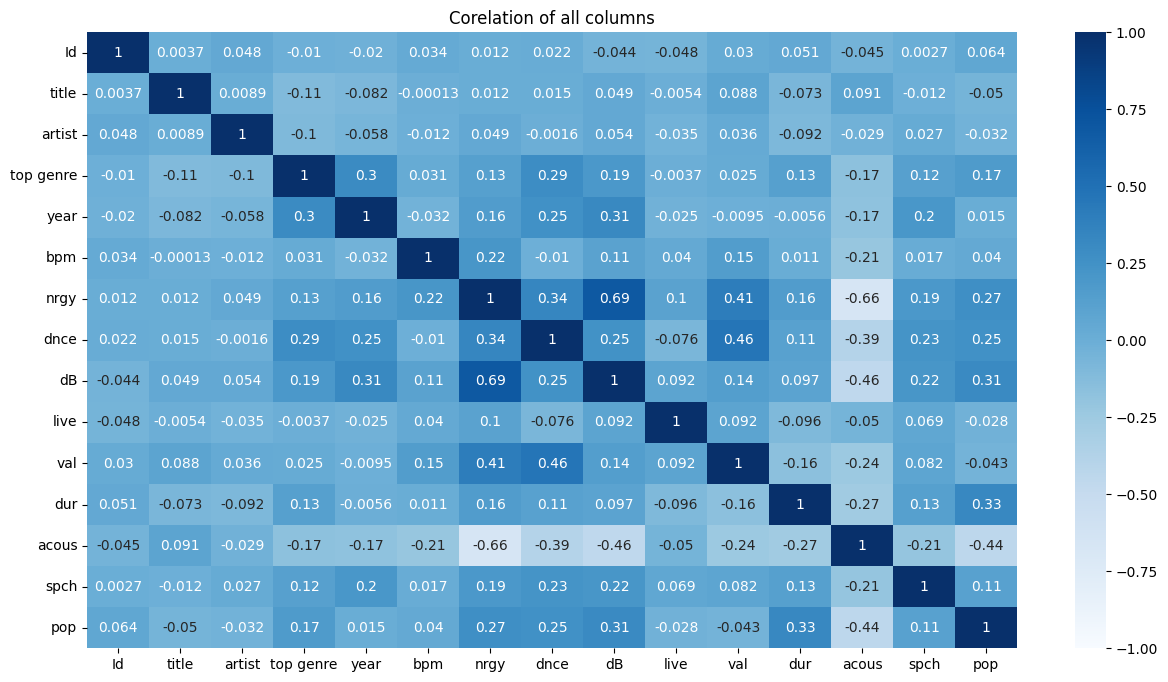

In [15]:
# corelation before remove outliner
corelation = trainDataClean.corr()
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(trainDataClean.corr(), center=0, cmap='Blues',vmin=-1, vmax=1, annot=True)
ax.set_title('Corelation of all columns')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


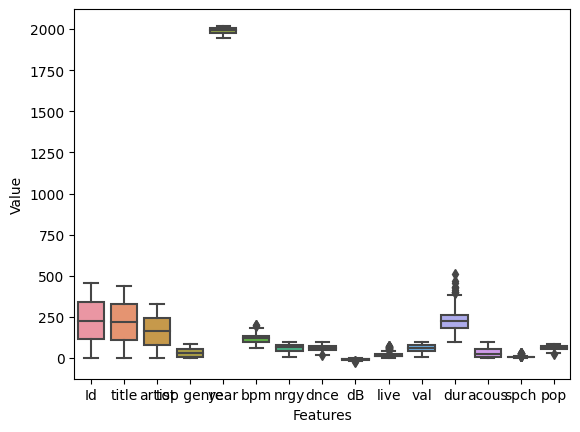

In [16]:
sns.boxplot(data=trainDataClean)
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

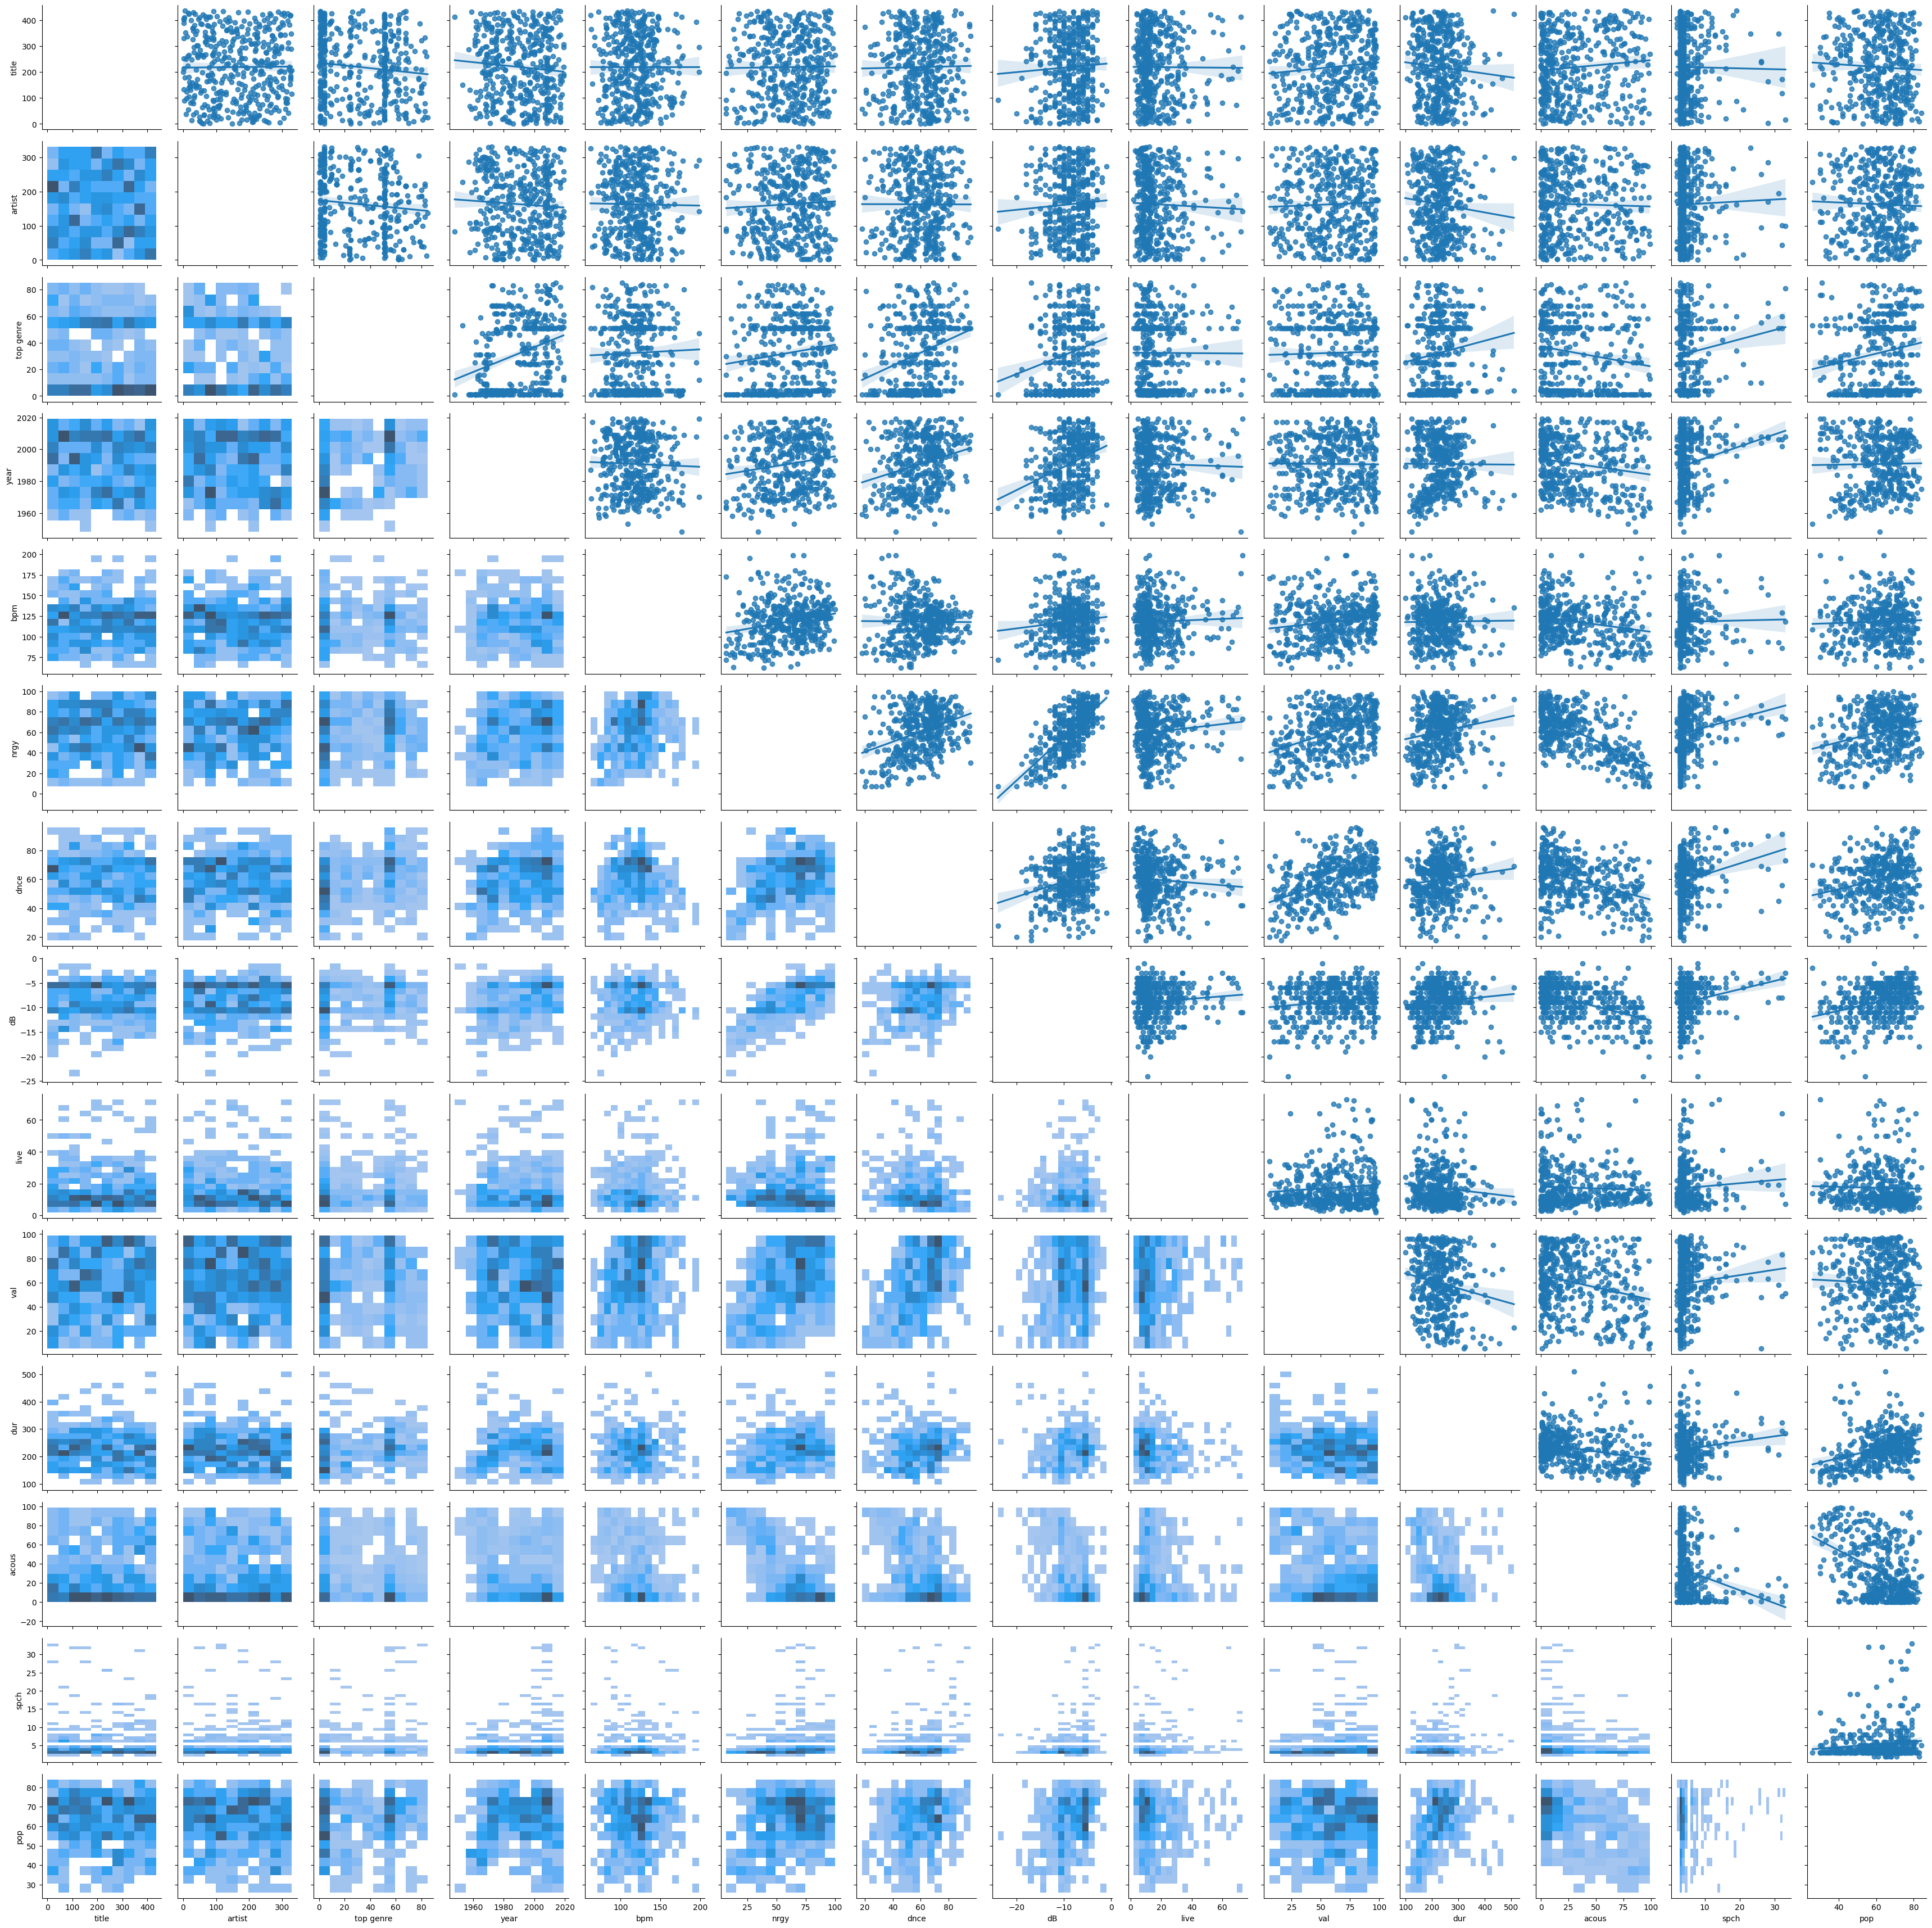

In [17]:
grid = sns.PairGrid(trainDataClean.drop(columns=["Id"]))

grid.map_upper(sns.regplot)
grid.map_lower(sns.histplot)

In [18]:
# after the extraction of outliner and empty cell
# from the corelation matrix, we can find that there are a number of columns that have a correlation over 0.1
# list as following, "top genre","nrgy","dnce","spch","dB","dur","year"
# form the pair grid, we can find there is a trend between "nrgy, db and dnce" and "dur, top genre and pop"

In [19]:
# seperated list - train data
# seperate x and y
y = trainDataClean["pop"]
x = trainDataClean[["top genre","nrgy","dnce","spch","dB","dur","year"]]
# scale the data before using 
stdScaler = StandardScaler()
xScaled = stdScaler.fit_transform(x)

# for polynomial 
polyFeat = PolynomialFeatures(degree=2, include_bias=False)
xPoly = polyFeat.fit_transform(x)
xPolyScaled = stdScaler.fit_transform(xPoly)


# for first training - scaled
xTrain, xTrainTest, yTrain, yTrainTest = train_test_split(x, y, test_size=0.25, random_state=42)

# for first training - scaled
xTrainS, xTrainSTest, yTrainS, yTrainSTest = train_test_split(xScaled, y, test_size=0.25, random_state=42)

# for first training - scaled poly
xTrainPoly, xTrainPolyTest, yTrainPoly, yTrainPolyTest = train_test_split(xPolyScaled, y, test_size=0.25, random_state=42)


In [20]:
# seperate list - test data
#xTest = testDataClean.drop(columns=["top genre","Id","artist","title","year"])
yTest = testDataClean["Id"]
xTest = testDataClean[["top genre","nrgy","dnce","spch","dB","dur","year"]]
yTestPred = testDataClean["pop"]

xScaledTest = stdScaler.fit_transform(xTest)

polyFeat = PolynomialFeatures(degree=2, include_bias=False)
xPolyScaledTest = polyFeat.fit_transform(xTest)
xPolyScaledTestScaled = stdScaler.fit_transform(xPolyScaledTest)


In [21]:
# function to write the Id and classification result to a CSV file
def toCsvFile(yPred, Id,axis,fileName):
    predTestdf = pd.DataFrame(yPred)
    result = pd.concat([Id, predTestdf], axis=1, ignore_index=True)
    result = result.set_axis(axis, axis=1)
    result.to_csv(fileName,index=False)
    print("Exported to ",fileName)


In [22]:
# function for RMSE genreation 
def score(ytestPred,yPred,algo="this algotrithm"):
    linearMse = mean_squared_error(ytestPred, yPred)
    linearRmse = np.sqrt(linearMse)
    print("RMSE of",algo,":",linearRmse)

In [23]:
# function to fit model and decode and call the score function
def fitModel(model,trainX,trainY,testX,algo="this algotrithm",decode=False,testY=None):
    model.fit(trainX,trainY)
    yPred = model.predict(testX)
    if decode:
        yPred = encoder.inverse_transform(yPred)
        #print(yPred)
    if testY is not None:
        score(yPred,testY,algo)
    return yPred


In [24]:
# 1)Decision Tree Regression
# scaled x is not applied for this sample as decision tree do not require scaling
treeClf = DecisionTreeRegressor(min_samples_leaf=5) 
# train
fitModel(treeClf,xTrain, yTrain,xTrainTest,"Decision Tree Train",False,yTrainTest)

# test
yPred = fitModel(treeClf,x, y,xTest,"Decision Tree Test",False,yTestPred)
toCsvFile(yPred,yTest,['Id','pop'],"regression_Tree_Grp3.csv")


RMSE of Decision Tree Train : 9.908619365409981
RMSE of Decision Tree Test : 11.147198125985254
Exported to  regression_Tree_Grp3.csv


In [25]:
# 2) poly SVR
# instead of scaled x , we use scaled polynomial featured x (degree=2)as we are going to apply poly SVR(degree=2))
polySVR = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
# train
fitModel(polySVR,xTrainPoly, yTrainPoly,xTrainPolyTest,"Poly SVR Train",False,yTrainTest)

# test
yPred = fitModel(polySVR,xPolyScaled,y,xPolyScaledTestScaled,"Poly SVR Test",False,yTestPred)
toCsvFile(yPred,yTest,['Id','pop'],"regression_Poly_SVC_Grp3.csv")


RMSE of Poly SVR Train : 12.615361642734495
RMSE of Poly SVR Test : 10.373258914777875
Exported to  regression_Poly_SVC_Grp3.csv


In [26]:
# 3) bagging with polySVR
baggedPolySVRReg = BaggingRegressor(base_estimator=SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale"),n_estimators=10, random_state=0,bootstrap=True, n_jobs=-1)
# train
fitModel(baggedPolySVRReg,xTrainPoly, yTrainPoly,xTrainPolyTest,"Bagging with Poly SVR Train",False,yTrainTest)

# test
yPred = fitModel(baggedPolySVRReg,xPolyScaled,y,xPolyScaledTestScaled,"Bagging with Poly SVR Test",False,yTestPred)
toCsvFile(yPred,yTest,['Id','pop'],"regression_Poly_SVR_Grp3.csv")

RMSE of Bagging with Poly SVR Train : 12.173713318373272
RMSE of Bagging with Poly SVR Test : 10.772717066137183
Exported to  regression_Poly_SVR_Grp3.csv


In [27]:
# 4) bagging with randomForest
baggedRFReg = BaggingRegressor(base_estimator=RandomForestRegressor(max_leaf_nodes=50, n_jobs=-1),n_estimators=15, random_state=0,bootstrap=True, n_jobs=-1)

# train
fitModel(baggedRFReg,xTrainS, yTrainS,xTrainSTest,"Bagging Random Forest Train",False,yTrainSTest)

# test
yPred = fitModel(baggedRFReg,x, y,xTest,"Bagging Random Forest Test",False,yTestPred)
toCsvFile(yPred,yTest,['Id','pop'],"regression_Bagged_RF_Grp3.csv")

RMSE of Bagging Random Forest Train : 8.939693218070055
RMSE of Bagging Random Forest Test : 9.440945270290198
Exported to  regression_Bagged_RF_Grp3.csv


In [28]:
# check the importance of each feature
rf = RandomForestRegressor(max_leaf_nodes=50, n_jobs=-1)
rf.fit(xScaled,y)
rf.feature_importances_

array([0.08163163, 0.11733841, 0.07076515, 0.05465673, 0.08420559,
       0.4091369 , 0.18226559])

In [29]:
# 5) Gradient Boosting Regressor
gradBoostReg = GradientBoostingRegressor(random_state=0)
# train
fitModel(gradBoostReg,xTrainS, yTrainS,xTrainSTest,"Gradient Boosting Train",False,yTrainSTest)

# test
yPred = fitModel(gradBoostReg,x, y,xTest,"Gradient Boosting Test",False,yTestPred)
toCsvFile(yPred,yTest,['Id','pop'],"regression_Gradient_Boost_Grp3.csv")

RMSE of Gradient Boosting Train : 8.727714261133924
RMSE of Gradient Boosting Test : 9.724388810074656
Exported to  regression_Gradient_Boost_Grp3.csv


In [32]:
# 4) Extreme Gradient Boosting Regressor
from xgboost import XGBRegressor

xgbReg = XGBRegressor(n_estimators=50, max_depth=7, eta=0.1, subsample=0.9, colsample_bytree=0.8)
fitModel(xgbReg,xTrainS, yTrainS,xTrainSTest,"XGBoosting Train",False,yTrainSTest)

# test
yPred = fitModel(xgbReg,x, y,xTest,"XGBoosting Test",False,yTestPred)
toCsvFile(yPred,yTest,['Id','pop'],"regression_XGB_Grp3.csv")

RMSE of XGBoosting Train : 8.997896965124013
RMSE of XGBoosting Test : 8.73929527876737
Exported to  regression_XGB_Grp3.csv


In [31]:
# conclusion:
# we have tried Decision Tree (we learn from last semester), poly SVR (week 3), Bagging with Random Forest(week 4), Gradient Boosting Regressor(also week4),
# judging from the result : bagging from RF is the more suitable one